In [976]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import sklearn
from numpy import mean
from numpy import std
from numpy import sqrt
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [977]:
df=pd.read_csv('../data/used_car_dataset.csv')

In [978]:
df.shape

(9997, 14)

The following steps are data exploration/cleansing steps

In [979]:
df.isna().sum()

price             0
year              0
manufacturer      0
condition         0
cylinders         0
fuel              0
odometer        692
transmission      0
type              0
paint_color       0
F1                0
F2                0
F3                0
F4                0
dtype: int64

In [980]:
df.columns

Index(['price', 'year', 'manufacturer', 'condition', 'cylinders', 'fuel',
       'odometer', 'transmission', 'type', 'paint_color', 'F1', 'F2', 'F3',
       'F4'],
      dtype='object')

In [981]:
df.head()

,price,year,manufacturer,condition,cylinders,fuel,odometer,transmission,type,paint_color,F1,F2,F3,F4
0,21978.0,2016.0,ford,like new,6 cylinders,gas,80813.0,automatic,SUV,black,138,2.472286,0.059031,b
1,4185.0,2008.0,ford,good,8 cylinders,gas,201800.0,automatic,SUV,white,415,2.285245,0.046328,c
2,7693.0,2002.0,ford,excellent,6 cylinders,gas,145000.0,automatic,pickup,white,535,1.861461,0.158554,b
3,15778.0,2016.0,ford,excellent,4 cylinders,gas,50103.0,automatic,sedan,white,3435,2.331671,0.213665,c
4,10520.0,2005.0,ford,good,8 cylinders,gas,207663.0,automatic,truck,white,1212,2.061082,0.388724,b


/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='price'>

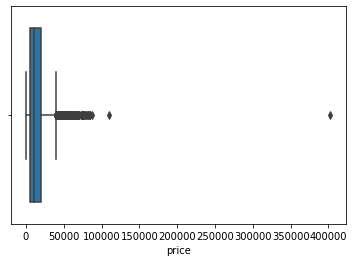

In [982]:
sns.boxplot(df['price'])

Unfortunately, I don't think that truck is actually $400,000

In [983]:
print(df[df['price']>300000])

         price    year manufacturer  condition    cylinders fuel  odometer  \
1722  402498.0  2016.0         ford  excellent  6 cylinders  gas   59000.0   

     transmission    type paint_color   F1        F2        F3 F4  
1722    automatic  pickup       black  155  2.443044  0.166662  c  


In [984]:
df=df[df['price']<300000]
df=df[df['price']>0]


Text(0, 0.5, 'Frequency')

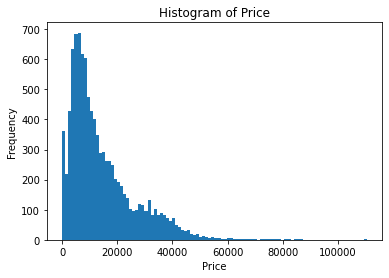

In [985]:
plt.hist(df['price'],bins=100)
plt.title('Histogram of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')

Having gotten rid of the clear outlier, we now have more of a choice of what to do with the points that the boxplot characterization still believes are outliers. They're prices that make sense for some types of cars, so ultimately I decide to leave these points in as I don't want to unnecessarily restrict the dataset. But the data is clearly skewed, which may pose problems for linear regression.

/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='price'>

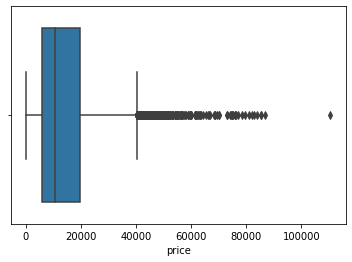

In [986]:
sns.boxplot(df['price'])

/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='year'>

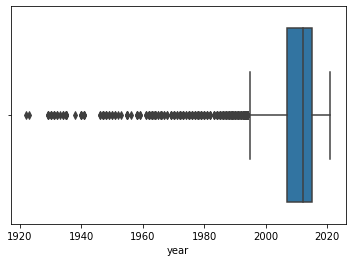

In [987]:
sns.boxplot(df['year'])

The following are to find the right level to cut the odometer at, which was a bit difficult as a few major outliers
made it difficult to see. I set the values to na as I assume they are mostly entry errors. Eventually I drop all na's, but setting these to na would allow imputation to these values if one chose to do so

/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='odometer'>

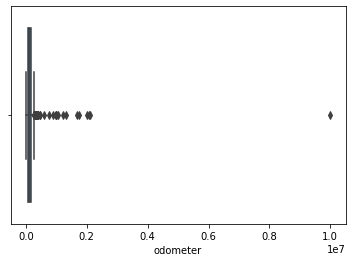

In [988]:
sns.boxplot(df['odometer'].dropna())

In [989]:
print(df[df['odometer']>5000000])

       price    year manufacturer condition    cylinders fuel   odometer  \
3351  2603.0  1996.0         ford      good  8 cylinders  gas  9999999.0   

     transmission type paint_color  F1        F2        F3 F4  
3351    automatic  SUV       white  78  1.898153  0.051428  a  


In [990]:
df.loc[df['odometer']>5000000,'odometer']=np.nan
print(df.iloc[3351,:])

price                9828.0
year                 2013.0
manufacturer           ford
condition         excellent
cylinders       6 cylinders
fuel                    gas
odometer           138633.0
transmission      automatic
type                    SUV
paint_color           white
F1                     1690
F2                 2.195113
F3                 0.129267
F4                        b
Name: 3395, dtype: object


/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='odometer'>

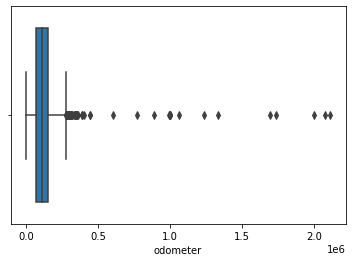

In [991]:
sns.boxplot(df['odometer'].dropna())

In [992]:
print(df[df['odometer']>1000000])

       price    year manufacturer  condition    cylinders fuel   odometer  \
683   1949.0  1997.0         ford       good  6 cylinders  gas  2110000.0   
1959  7825.0  2003.0         ford  excellent  8 cylinders  gas  1690000.0   
3869  4024.0  2002.0         ford  excellent  6 cylinders  gas  2074484.0   
4454  6588.0  2003.0         ford       good  8 cylinders  gas  1330000.0   
7231  8475.0  1995.0         ford       good  6 cylinders  gas  1062450.0   
9063  3812.0  2003.0         ford       good  8 cylinders  gas  1737004.0   
9632  2597.0  2007.0         ford       fair  6 cylinders  gas  2000000.0   
9645   500.0  1999.0         ford       good  8 cylinders  gas  1234567.0   

     transmission    type paint_color   F1        F2        F3 F4  
683     automatic   sedan      silver  103  1.923743  0.218098  c  
1959    automatic     SUV       white  345  2.082982  0.089149  b  
3869    automatic     SUV      silver  259  2.016615  0.074513  b  
4454    automatic     SUV       wh

In [993]:
df.loc[df['odometer']>1000000,'odometer']=np.nan

/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='odometer'>

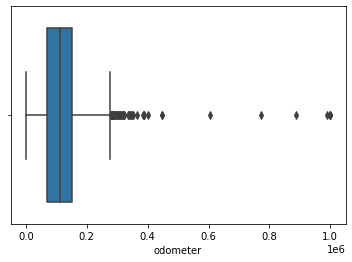

In [994]:
sns.boxplot(df['odometer'].dropna())

In [995]:
print(df[df['odometer']>500000])

        price    year manufacturer  condition    cylinders fuel   odometer  \
618    2033.0  2004.0         ford       good  8 cylinders  gas  1000000.0   
690   10172.0  2008.0         ford  excellent  4 cylinders  gas   990000.0   
1205  16204.0  2016.0         ford  excellent  4 cylinders  gas   999745.0   
1345  12390.0  2014.0         ford  excellent  6 cylinders  gas   771354.0   
2062  24151.0  1940.0         ford       good  8 cylinders  gas   999999.0   
3035   1743.0  1978.0         ford       fair  8 cylinders  gas   606030.0   
8088   1792.0  1955.0         ford       fair  8 cylinders  gas   888999.0   
9198  19632.0  1940.0         ford       good  8 cylinders  gas   999999.0   

     transmission    type paint_color   F1        F2        F3 F4  
618     automatic     SUV       black  557  1.924468  0.022897  a  
690     automatic   sedan       black  113  2.105780  0.130174  c  
1205    automatic   sedan       black   68  2.251897  0.121695  a  
1345    automatic     SUV

In [996]:
df.loc[df['odometer']>500000,'odometer']=np.nan

/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='odometer'>

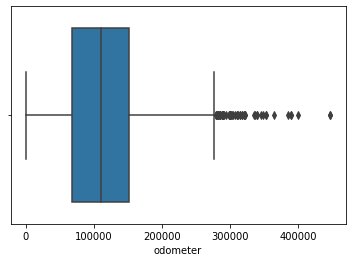

In [997]:
sns.boxplot(df['odometer'].dropna())

Rescaling odometer to be more interpretable

In [998]:
df['odometer']=df['odometer']/1000

/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='F1'>

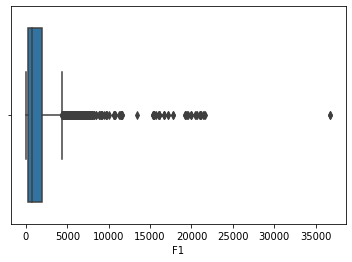

In [999]:
sns.boxplot(df['F1'])

/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='F2'>

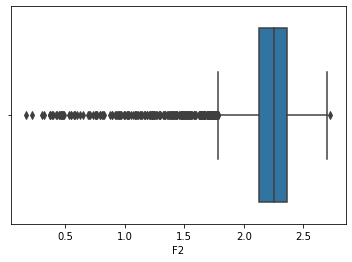

In [1000]:
sns.boxplot(df['F2'])

/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='F3'>

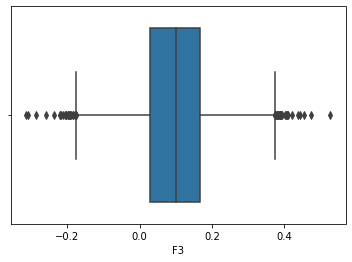

In [1001]:
sns.boxplot(df['F3'])

In [1002]:
df.isna().sum()

price             0
year              0
manufacturer      0
condition         0
cylinders         0
fuel              0
odometer        692
transmission      0
type              0
paint_color       0
F1                0
F2                0
F3                0
F4                0
dtype: int64

In [1003]:
df.shape

(9866, 14)

In [1004]:
clean=df.dropna()
clean.shape

(9174, 14)

These are now the distributions of the categorical variables, run to ensure there were no erroneous/nonsensical categories

Text(0.5, 0, 'manufacturer')

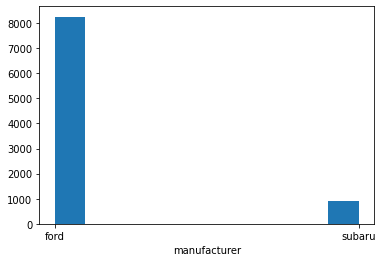

In [1005]:
x='manufacturer'
plt.hist(clean[x])
plt.xlabel(x)

Text(0.5, 0, 'condition')

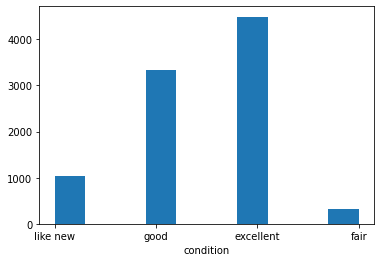

In [1006]:
x='condition'
plt.hist(clean[x])
plt.xlabel(x)

Text(0.5, 0, 'cylinders')

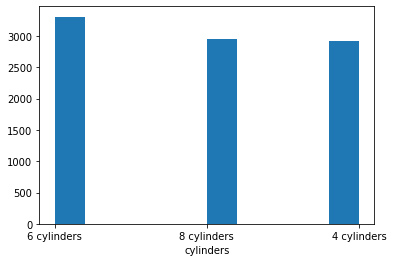

In [1007]:
x='cylinders'
plt.hist(clean[x])
plt.xlabel(x)

Gas is the only fuel type, so it will be dropped as a feature as there can't be any signal from the feature

Text(0.5, 0, 'fuel')

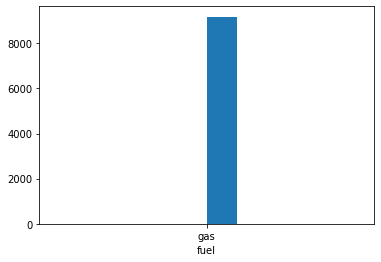

In [1008]:
x='fuel'
plt.hist(clean[x])
plt.xlabel(x)

In [1009]:
clean=clean.drop(columns=['fuel'])

Text(0.5, 0, 'transmission')

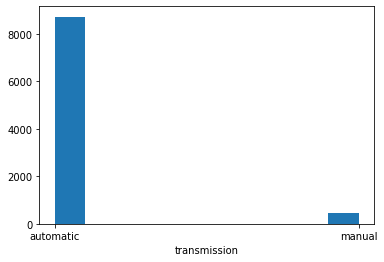

In [1010]:
x='transmission'
plt.hist(clean[x])
plt.xlabel(x)

Text(0.5, 0, 'type')

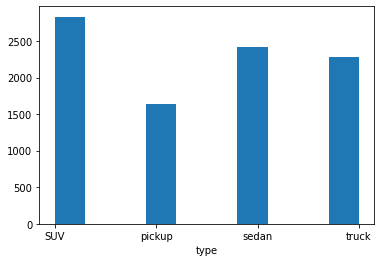

In [1011]:
x='type'
plt.hist(clean[x])
plt.xlabel(x)

Text(0.5, 0, 'paint_color')

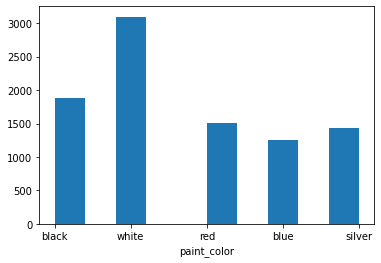

In [1012]:
x='paint_color'
plt.hist(clean[x])
plt.xlabel(x)

Text(0.5, 0, 'F4')

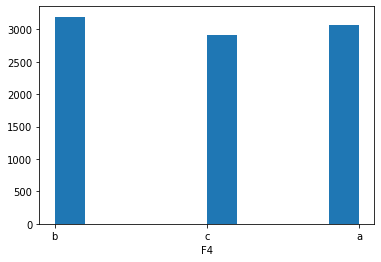

In [1013]:
x='F4'
plt.hist(clean[x])
plt.xlabel(x)

We now get dummy variables for each of the categorical variables. Importantly, we drop one of the columns for each category. Failing to do so would result in perfect colinearity between that category.

In [1014]:
clean=pd.get_dummies(clean,columns=['manufacturer','F4','paint_color','type','transmission','cylinders','condition'],drop_first=True)

In [1015]:
clean.head()

,price,year,odometer,F1,F2,F3,manufacturer_subaru,F4_b,F4_c,paint_color_blue,...,paint_color_white,type_pickup,type_sedan,type_truck,transmission_manual,cylinders_6 cylinders,cylinders_8 cylinders,condition_fair,condition_good,condition_like new
0,21978.0,2016.0,80.813,138,2.472286,0.059031,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
1,4185.0,2008.0,201.800,415,2.285245,0.046328,0,0,1,0,...,1,0,0,0,0,0,1,0,1,0
2,7693.0,2002.0,145.000,535,1.861461,0.158554,0,1,0,0,...,1,1,0,0,0,1,0,0,0,0
3,15778.0,2016.0,50.103,3435,2.331671,0.213665,0,0,1,0,...,1,0,1,0,0,0,0,0,0,0
4,10520.0,2005.0,207.663,1212,2.061082,0.388724,0,1,0,0,...,1,0,0,1,0,0,1,0,1,0


In [1016]:
clean.columns

Index(['price', 'year', 'odometer', 'F1', 'F2', 'F3', 'manufacturer_subaru',
       'F4_b', 'F4_c', 'paint_color_blue', 'paint_color_red',
       'paint_color_silver', 'paint_color_white', 'type_pickup', 'type_sedan',
       'type_truck', 'transmission_manual', 'cylinders_6 cylinders',
       'cylinders_8 cylinders', 'condition_fair', 'condition_good',
       'condition_like new'],
      dtype='object')

A correlation matrix is shown below, to try to anticipate what features might be important to the price as well as any issues of colinearity we might see

In [1017]:
corr=clean.corr()
corr.style.background_gradient(cmap='coolwarm')

,price,year,odometer,F1,F2,F3,manufacturer_subaru,F4_b,F4_c,paint_color_blue,paint_color_red,paint_color_silver,paint_color_white,type_pickup,type_sedan,type_truck,transmission_manual,cylinders_6 cylinders,cylinders_8 cylinders,condition_fair,condition_good,condition_like new
price,1.000000,0.417142,-0.534579,0.229151,0.361340,0.108461,-0.049789,-0.009402,0.011558,-0.022307,0.007200,-0.078088,0.038463,0.220416,-0.283242,0.214951,-0.066430,0.098011,0.107904,-0.171231,-0.092388,0.158559
year,0.417142,1.000000,-0.340593,0.201439,0.873843,0.008075,0.068793,-0.009907,-0.000476,-0.048347,-0.070705,0.048275,0.030951,-0.049670,0.028040,-0.070166,-0.232027,0.068606,-0.266054,-0.226319,-0.152767,0.143012
odometer,-0.534579,-0.340593,1.000000,-0.220372,-0.296012,-0.012179,-0.044500,0.013684,0.013984,-0.030769,-0.038961,0.007836,0.043250,-0.041118,-0.051456,0.039117,-0.002245,-0.011132,0.155812,0.183650,0.139687,-0.166262
F1,0.229151,0.201439,-0.220372,1.000000,0.172647,0.002321,-0.037717,-0.002066,-0.005452,0.021905,0.009523,-0.041533,0.013662,0.107554,-0.025453,-0.052456,-0.039721,0.040377,-0.026696,-0.093445,-0.054485,-0.047251
F2,0.361340,0.873843,-0.296012,0.172647,1.000000,0.017404,0.073337,-0.009291,-0.005487,-0.044502,-0.060837,0.038848,0.032860,-0.053353,0.027355,-0.063431,-0.200085,0.052350,-0.237473,-0.193025,-0.127517,0.123202
F3,0.108461,0.008075,-0.012179,0.002321,0.017404,1.000000,-0.002947,0.007723,0.009816,0.007167,0.006179,-0.001015,-0.009456,0.001294,-0.001317,0.010285,0.003870,0.002226,-0.000305,-0.000157,0.000574,0.007256
manufacturer_subaru,-0.049789,0.068793,-0.044500,-0.037717,0.073337,-0.002947,1.000000,-0.013577,0.014920,0.114747,-0.004704,0.076134,-0.110537,-0.148172,0.170403,-0.186279,0.229954,-0.210376,-0.228676,-0.026813,-0.049338,0.015962
F4_b,-0.009402,-0.009907,0.013684,-0.002066,-0.009291,0.007723,-0.013577,1.000000,-0.497987,0.004753,-0.019760,0.001370,0.003909,0.023639,-0.003965,-0.012552,0.000934,0.008683,0.019100,-0.010557,0.005975,-0.008162
F4_c,0.011558,-0.000476,0.013984,-0.005452,-0.005487,0.009816,0.014920,-0.497987,1.000000,-0.006383,0.018635,0.006582,-0.024454,-0.013213,0.012975,-0.001999,0.005516,-0.005628,-0.016126,-0.000642,-0.007555,0.009201
paint_color_blue,-0.022307,-0.048347,-0.030769,0.021905,-0.044502,0.007167,0.114747,0.004753,-0.006383,1.000000,-0.176413,-0.170919,-0.284061,0.026827,0.046245,-0.067930,0.084174,0.015655,-0.074719,0.028063,0.022886,-0.003161


Getting an understanding of the relationship between year and price for general understanding

In [1018]:
price_by_year=clean[['year','price']].groupby('year',as_index=False).median()
diffs=[]
for i in range(len(price_by_year)):
    if i!=len(price_by_year)-1:
        diff=price_by_year.iloc[i+1,1]-price_by_year.iloc[i,1]
    else:
        diff=0
    diffs.append(diff)
price_by_year['diff']=diffs
price_by_year=price_by_year[price_by_year['year']>1980]

Text(0, 0.5, 'Yearly Change')

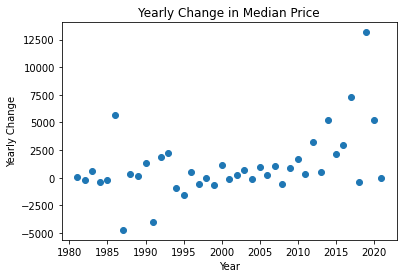

In [1019]:
plt.scatter(price_by_year['year'],price_by_year['diff'])
plt.title('Yearly Change in Median Price')
plt.xlabel('Year')
plt.ylabel('Yearly Change')

Fitting a basic linear model

In [1020]:
X=clean[['year', 'odometer', 'F1', 'F2', 'F3', 'manufacturer_subaru',
       'F4_b', 'F4_c', 'paint_color_blue', 'paint_color_red',
       'paint_color_silver', 'paint_color_white', 'type_pickup', 'type_sedan',
       'type_truck', 'transmission_manual', 'cylinders_6 cylinders',
       'cylinders_8 cylinders', 'condition_fair', 'condition_good',
       'condition_like new']]
Y=clean['price']

In [1021]:
X_sm=sm.add_constant(X)
model=sm.OLS(Y,X_sm)
results=model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     551.8
Date:                Wed, 10 Feb 2021   Prob (F-statistic):               0.00
Time:                        19:57:48   Log-Likelihood:                -95475.
No. Observations:                9174   AIC:                         1.910e+05
Df Residuals:                    9152   BIC:                         1.912e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -9.438e+

Getting the VIF values for each feature. They are very high for year and F2, so they will be dropped as features for now. The model will then be refit without these features.

In [1022]:
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

year                     204.251489
odometer                   5.330760
F1                         1.667025
F2                       164.920209
F3                         1.981887
manufacturer_subaru        1.478843
F4_b                       2.046408
F4_c                       1.951188
paint_color_blue           1.700829
paint_color_red            1.827682
paint_color_silver         1.783599
paint_color_white          2.733247
type_pickup                1.973096
type_sedan                 2.095363
type_truck                 2.443639
transmission_manual        1.207553
cylinders_6 cylinders      3.264272
cylinders_8 cylinders      4.354145
condition_fair             1.158635
condition_good             1.839358
condition_like new         1.268233
dtype: float64

In [1023]:
X1=X.drop(columns=['year','F2'])
pd.Series([variance_inflation_factor(X1.values, i) 
               for i in range(X1.shape[1])], 
              index=X1.columns)

odometer                 4.191041
F1                       1.514463
F3                       1.882204
manufacturer_subaru      1.372674
F4_b                     1.898383
F4_c                     1.810329
paint_color_blue         1.547419
paint_color_red          1.620272
paint_color_silver       1.571189
paint_color_white        2.362882
type_pickup              1.934056
type_sedan               1.769882
type_truck               2.379090
transmission_manual      1.148276
cylinders_6 cylinders    2.706238
cylinders_8 cylinders    3.819306
condition_fair           1.140284
condition_good           1.807724
condition_like new       1.213048
dtype: float64

In [1024]:
X_sm=sm.add_constant(X1)
model=sm.OLS(Y,X_sm)
results=model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     459.6
Date:                Wed, 10 Feb 2021   Prob (F-statistic):               0.00
Time:                        19:57:50   Log-Likelihood:                -96155.
No. Observations:                9174   AIC:                         1.924e+05
Df Residuals:                    9154   BIC:                         1.925e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  2.083e+

A plot of the residuals is shown below. There is a major issue. The actual vs predicted plot looks gross and the residuals are clearly decreasing, which violates an assumption of OLS. Like I hinted at earlier, this might have to do with the values the boxplot classified as outliers beyond a price of about $40,000.

R2 score: 0.4881888611430819
RMSE: 8624.468759139147


Text(0, 0.5, 'predicted_price')

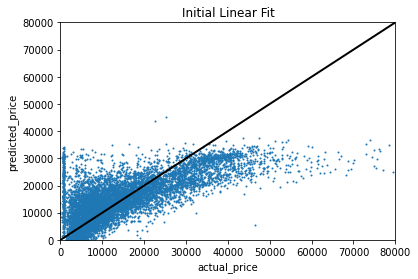

In [1025]:
preds=results.predict(X_sm)
print('R2 score:', r2_score(Y,preds))
print('RMSE:', sqrt(mean_squared_error(Y,preds)))
plt.scatter(Y,preds,s=1)
plt.plot([0, 80000], [0, 80000], color = 'black', linewidth = 2)
plt.xlim(0,80000)
plt.ylim(0,80000)
plt.title('Initial Linear Fit')
plt.xlabel('actual_price')
plt.ylabel('predicted_price')

Text(0.5, 1.0, 'Residuals')

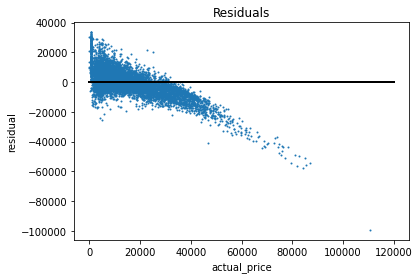

In [1026]:
preds=results.predict(X_sm)
residuals=preds-Y
plt.scatter(Y,residuals,s=1)
plt.plot([0, 120000], [0, 0], color = 'black', linewidth = 2)
plt.xlabel('actual_price')
plt.ylabel('residual')
plt.title('Residuals')

To try to remedy this, a log transform of the price+1 is taken as will be fit to as the new response variable. The +1 is to simply be able to include values of 0 and will not affect the overall results of the model as 1 is negligible to the overall price.

In [1027]:
clean['price']+=1
clean['log_price']=np.log(clean['price'])

In [1028]:
X=clean[['odometer', 'F1', 'F3', 'manufacturer_subaru', 'F4_b',
       'F4_c', 'paint_color_blue', 'paint_color_red', 'paint_color_silver',
       'paint_color_white', 'type_pickup', 'type_sedan', 'type_truck',
       'transmission_manual', 'cylinders_6 cylinders', 'cylinders_8 cylinders',
       'condition_fair', 'condition_good', 'condition_like new']]
Y=clean['log_price']
X_sm=sm.add_constant(X)
model=sm.OLS(Y,X_sm)
results=model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     246.8
Date:                Wed, 10 Feb 2021   Prob (F-statistic):               0.00
Time:                        19:57:51   Log-Likelihood:                -10708.
No. Observations:                9174   AIC:                         2.146e+04
Df Residuals:                    9154   BIC:                         2.160e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     9.74

A residual plot is shown below. It's still decreasing, but it looks...a little better. Maybe? The model clearly isn't good at predicting cars that have an actual value of 0. I'm not sure and I'm starting to think that a simple linear approach isn't best for this data, or I should have dropped those larger prices. But, dropping the larger prices because they're making this hard is taking the easy way out. Since this residual plot looks a bit better to me and taking the log makes sense given the somewhat skewed nature of the car price, I'm going to use the log(price) going forward.

R2 score: 0.33869373716161544
RMSE: 0.7774562525244068


Text(0.5, 1.0, 'Fit to log(price)')

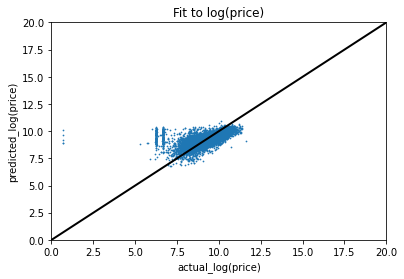

In [1029]:
preds=results.predict(X_sm)
print('R2 score:', r2_score(Y,preds))
print('RMSE:', sqrt(mean_squared_error(Y,preds)))
plt.scatter(Y,preds,s=.5)
plt.plot([0, 20], [0, 20], color = 'black', linewidth = 2)
plt.xlim(0,20)
plt.ylim(0,20)
plt.xlabel('actual_log(price)')
plt.ylabel('predicted_log(price)')
plt.title('Fit to log(price)')

Text(0.5, 1.0, 'Residuals')

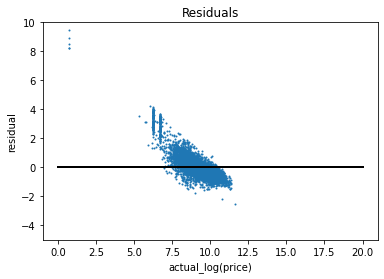

In [1030]:
preds=results.predict(X_sm)
residuals=preds-Y
plt.scatter(Y,residuals,s=1)
plt.plot([0, 20], [0, 0], color = 'black', linewidth = 2)
plt.ylim((-5,10))
plt.xlabel('actual_log(price)')
plt.ylabel('residual')
plt.title('Residuals')

One more shot at taking the log of year, since I would like to include year in the linear model but it clearly has a non-linear relationship. The adj-R2 improves, but log(year) still has an extremely high VIF and the residuals aren't any better, so I'll leave it out of the final model comparisons

In [1031]:
clean['log_year']=np.log(clean['year'])
X=clean[['log_year','odometer', 'F1', 'F3', 'manufacturer_subaru', 'F4_b',
       'F4_c', 'paint_color_blue', 'paint_color_red', 'paint_color_silver',
       'paint_color_white', 'type_pickup', 'type_sedan', 'type_truck',
       'transmission_manual', 'cylinders_6 cylinders', 'cylinders_8 cylinders',
       'condition_fair', 'condition_good', 'condition_like new']]
Y=clean['log_price']
X_sm=sm.add_constant(X)
model=sm.OLS(Y,X_sm)
results=model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     297.0
Date:                Wed, 10 Feb 2021   Prob (F-statistic):               0.00
Time:                        19:57:52   Log-Likelihood:                -10310.
No. Observations:                9174   AIC:                         2.066e+04
Df Residuals:                    9153   BIC:                         2.081e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  -507.33

In [1032]:
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

log_year                 18.858506
odometer                  5.133939
F1                        1.644607
F3                        1.981316
manufacturer_subaru       1.476286
F4_b                      2.046335
F4_c                      1.950980
paint_color_blue          1.696538
paint_color_red           1.821829
paint_color_silver        1.783508
paint_color_white         2.731448
type_pickup               1.971513
type_sedan                2.089070
type_truck                2.437583
transmission_manual       1.148412
cylinders_6 cylinders     3.226374
cylinders_8 cylinders     4.155068
condition_fair            1.140323
condition_good            1.832914
condition_like new        1.264354
dtype: float64

Text(0.5, 1.0, 'Residuals')

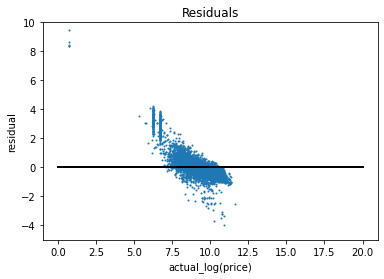

In [1033]:
preds=results.predict(X_sm)
residuals=preds-Y
plt.scatter(Y,residuals,s=1)
plt.plot([0, 20], [0, 0], color = 'black', linewidth = 2)
plt.ylim((-5,10))
plt.xlabel('actual_log(price)')
plt.ylabel('residual')
plt.title('Residuals')

Now for choosing the best model. Methodology: split into training and testing data. Perform a cross validation with 5 splits on the training data. For the linear model, we know to drop year and F2 from our previous VIF scores. For Ridge, Lasso, and Elastic, we perform a grid search for the optimal parameters for that model.

In [1086]:
X=clean[['year','odometer', 'F1', 'F2','F3', 'manufacturer_subaru', 'F4_b',
       'F4_c', 'paint_color_blue', 'paint_color_red', 'paint_color_silver',
       'paint_color_white', 'type_pickup', 'type_sedan', 'type_truck',
       'transmission_manual', 'cylinders_6 cylinders', 'cylinders_8 cylinders',
       'condition_fair', 'condition_good', 'condition_like new']]
Y=clean['log_price']
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=.2,random_state=1234)
cv = KFold(n_splits=5, random_state=1234, shuffle=True)

In [1080]:
linear_x=x_train.drop(columns=['year','F2'])

In [1081]:
linreg=LinearRegression()
linregscore=cross_val_score(linreg, linear_x, y_train, scoring='neg_root_mean_squared_error', cv=cv)

In [1082]:
print('RMSE: %.3f' % (mean(linregscore)))

RMSE: -0.779


In [1063]:
ridge = Ridge()
grid = dict()
grid['alpha'] = np.arange(0, 10, 0.1)

In [1064]:
ridge_search=GridSearchCV(ridge, grid, scoring='neg_root_mean_squared_error', cv=cv)
ridge_results = ridge_search.fit(x_train, y_train)
print('RMSE: %.3f' % ridge_results.best_score_)
print('Config: %s' % ridge_results.best_params_)

RMSE: -0.747
Config: {'alpha': 2.9000000000000004}


In [1065]:
lasso=Lasso()
grid = dict()
grid['alpha'] = np.arange(0, 10, 0.1)

It is safe to ignore the warnings about the lack of convergence when alpha=0.

In [1066]:
lasso_search=GridSearchCV(lasso, grid, scoring='neg_root_mean_squared_error', cv=cv)
lasso_results = lasso_search.fit(x_train, y_train)
print('RMSE: %.3f' % lasso_results.best_score_)
print('Config: %s' % lasso_results.best_params_)

/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1662.1649778984568, tolerance: 0.538544683582582
  positive)
/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegres

RMSE: -0.747
Config: {'alpha': 0.0}


/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2034.5395550287083, tolerance: 0.6682168296836826
  positive)


In [1073]:
elastic=ElasticNet()
grid = dict()
grid['alpha'] = np.arange(0, 1, 0.05)
grid['l1_ratio'] = np.arange(0.001, 1, 0.05)

In [1074]:
elastic_search=GridSearchCV(elastic, grid, scoring='neg_root_mean_squared_error', cv=cv)
elastic_results = elastic_search.fit(x_train, y_train)


/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1662.1649778984568, tolerance: 0.538544683582582
  positive)
/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegres

/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1662.1649778984568, tolerance: 0.538544683582582
  positive)
/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations.

/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1628.5427308180208, tolerance: 0.5349171739935896
  positive)
/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1646.0526709611286, tolerance: 0.543919674493815
  positive)
/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegres

/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1602.955075848672, tolerance: 0.5294924533255315
  positive)
/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegres

/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1662.1649778984568, tolerance: 0.538544683582582
  positive)
/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegres

/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1662.1649778984568, tolerance: 0.538544683582582
  positive)
/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations.

/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1628.5427308180208, tolerance: 0.5349171739935896
  positive)
/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1646.0526709611286, tolerance: 0.543919674493815
  positive)
/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegres

/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1646.0526709611286, tolerance: 0.543919674493815
  positive)
/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/maxlee/dsci552/virtual_env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations.

In [1075]:
print('RMSE: %.3f' % elastic_results.best_score_)
print('Config: %s' % elastic_results.best_params_)

RMSE: -0.747
Config: {'alpha': 0.0, 'l1_ratio': 0.001}


Interestingly, the performance of Ridge, Lasso, and Elastic Net are all equivalent. Further, the optimal value of Lasso is alpha=0, which is just a linear model! So maybe we shouldn't have dropped year and F2. Now rerun the linear model, with all features just to verify.

In [1067]:
linreg=LinearRegression()
linregscore=cross_val_score(linreg, x_train, y_train, scoring='neg_root_mean_squared_error', cv=cv)

In [1068]:
print('RMSE: %.3f' % (mean(linregscore)))

RMSE: -0.747


In [1089]:
X=x_train
Y=y_train
X_sm=sm.add_constant(X)
X_test=sm.add_constant(x_test)
model=sm.OLS(Y,X_sm)
results=model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     223.8
Date:                Wed, 10 Feb 2021   Prob (F-statistic):               0.00
Time:                        21:47:35   Log-Likelihood:                -8249.4
No. Observations:                7339   AIC:                         1.654e+04
Df Residuals:                    7317   BIC:                         1.669e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -57.31

In [1090]:
y_preds=results.predict(X_test)

Now for the final results:

R2 score: 0.40444857395852807
RMSE: 0.743016996982773


Text(0.5, 1.0, 'OLS All Features')

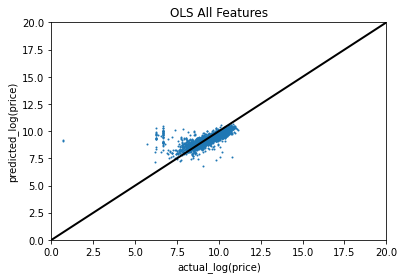

In [1093]:
print('R2 score:', r2_score(y_test,y_preds))
print('RMSE:', sqrt(mean_squared_error(y_test,y_preds)))
plt.scatter(y_test,y_preds,s=1)
plt.plot([0, 20], [0, 20], color = 'black', linewidth = 2)
plt.xlim(0,20)
plt.ylim(0,20)
plt.xlabel('actual_log(price)')
plt.ylabel('predicted_log(price)')
plt.title('OLS All Features')

Not bad! We have a decent R2 value of .4, and our RMSE in cross validation of .747 is actually beat in testing, albeit barely. There is clearly a positive trend between our prediction and the actual prediction. It is not perfectly linear, as we will see in the residual, but it's looking okay.

Text(0.5, 1.0, 'OLS All Features Residual')

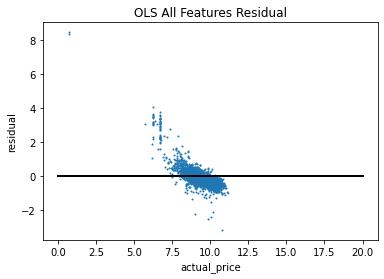

In [1095]:
residuals=y_preds-y_test
plt.scatter(y_test,residuals,s=1)
plt.plot([0, 20], [0, 0], color = 'black', linewidth = 2)
plt.xlabel('actual_price')
plt.ylabel('residual')
plt.title('OLS All Features Residual')

The residuals still aren't ideal, as they have a clear negative slope. They do look better than our initial attempt without the log, as the variance looks relatively consistent. There's more that could be done, such as looking at some non-linear models or implementing stricter outlier rejection. But for the sake of maintaining most of the data and keeping the model simple, this should be sufficient.